In [1]:
import os
import time
import json
import itertools as it
from collections import OrderedDict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from reaction_network.fjss import FJS2
import plotly.express as px

## Setup the inputs for the FJS2

In [2]:
random_seed = 42
rng = np.random.default_rng(random_seed)

json_file = "/home/fwmeng/work/schedular/simulator-aspire-poc/reaction_network_workplace/network_case0/step03_bench_top_lv2_temperature.json"
with open(json_file, "r") as f:
    json_data = json.load(f)

# mapping of operation type to device/machine
operation_machine_dict = json_data["operation_type_device_mapping"]

# TODO: not dealing with the devices field for now
# operation dict
operation_dict = json_data["operation_dict"]
operation_dict = OrderedDict(sorted(operation_dict.items()))
operation_df = pd.DataFrame(operation_dict).T
# get the unique machine list, which is the can_be_realized_by field in the operation_dict
machine_list = []
for machine in operation_df["can_be_realized_by"]:
    machine_list.extend(machine)
machine_list = list(set(machine_list))

# number of machines
num_machines = len(machine_list)
# number of operations
num_operations = len(operation_dict)

# simplified operations as a dictionary
# where each index is the string of integer index and the value is the operation type
operations = {
    str(i): operation["type"]
    for i, operation in zip(range(num_operations), operation_dict.values())
}
operations = OrderedDict(sorted(operations.items()))
# simplified machines as a dictionary
# where each index is the integer index and the value is the machine name
machines = {
    str(i): machine for i, machine in zip(range(len(machine_list)), machine_list)
}
machines = OrderedDict(sorted(machines.items()))
machines_name_id_dict = {machine: i for i, machine in machines.items()}
machines_name_id_dict = OrderedDict(sorted(machines_name_id_dict.items()))
machines_id_name_dict = {v: k for k, v in machines_name_id_dict.items()}
machines_id_name_dict = OrderedDict(sorted(machines_id_name_dict.items()))

In [3]:
# loop over the operation_dict and find type is OPERATION_HEATING
for key, value in operation_dict.items():
    if value["type"] == "OPERATION_HEATING":
        print(key, value)

49d8cd4e-cd6c-4b2b-841e-1905ad9582d8 {'id': '49d8cd4e-cd6c-4b2b-841e-1905ad9582d8', 'description': '', 'consumes': '648f464a-063f-447b-bd68-69d34d6a7bb3', 'produces': 'fb6c2880-f5ba-477d-b04e-2781ede8198c', 'precedents': ['45703ae4-90e8-413b-9844-2037f1d3f56a'], 'type': 'OPERATION_HEATING', 'can_be_realized_by': ['HEATER-2']}
7e2d73e2-5be0-48a0-bad5-b0be891f66f5 {'id': '7e2d73e2-5be0-48a0-bad5-b0be891f66f5', 'description': '', 'consumes': 'c3056044-18be-424e-8ee4-7b979c3cfcc5', 'produces': '487a4bb0-b2b5-4969-a338-db5a0a63c109', 'precedents': ['5def357d-24d7-42b6-a684-124d83e7b8ff'], 'type': 'OPERATION_HEATING', 'can_be_realized_by': ['HEATER-2']}
9c79bca7-251f-473e-a773-67579f624d7a {'id': '9c79bca7-251f-473e-a773-67579f624d7a', 'description': '', 'consumes': '7c013cf7-b9a1-4f10-8b65-6e6f7ce6a64f', 'produces': 'd3b1c8e7-15e1-40a8-9633-68caf5575617', 'precedents': ['57685b4c-68c2-49cf-8172-e72a62ae8690'], 'type': 'OPERATION_HEATING', 'can_be_realized_by': ['HEATER-2']}
a1363f1e-19d1-4d

In [4]:
# para_a: the setup time of machine m when processing operation i before j
# para_a_ijm = -inf if there is no setups
# TODO: for now, we assume there is no setup time, but needs to be updated in the future
para_a = np.full((num_operations, num_operations, num_machines), -np.inf)

# para_w: weight of operation i in machine m
# +inf as default value
# para_w = np.full((num_operations, num_machines), np.inf)
# para_w = np.zeros((num_operations, num_machines))
para_w = np.ones((num_operations, num_machines))

# para_h: extra time of operation i in machine m after being processed
# default value is 0 for now
# TODO: need to change to random value in the future
para_h = np.zeros((num_operations, num_machines))

# para_delta: input/output delay time between two consecutive operations in machine m
# this is related to loading and unloading time
# TODO: for now, we assume there is no delay time, but needs to be updated in the future
para_delta = np.zeros(num_machines)

# para_mach_capacity: the capacity of machine m
# TODO: for now, we assume the capacity of each machine is 1, but needs to be updated in the future
para_mach_capacity = np.full(num_machines, 1)

operations_subset_indices = []

# para_p
# processing time of operation i in machine m,
# p_im = +inf if operation i cannot be realized by machine m
# shape = (num_operations, num_machines)
para_p = np.full((num_operations, num_machines), np.inf)
for i, operation in enumerate(operation_dict.values()):
    needs_ws = [
        mach
        for mach in operation["can_be_realized_by"]
        if "ACC" in mach or "WORKER" in mach
    ]
    if len(needs_ws) > 0:
        operations_subset_indices.append(i)
    for machine in operation["can_be_realized_by"]:
        m = machines_name_id_dict.get(machine)
        # set random operation time based on the operation type
        # OPERATION_UNLOADING: random integer between 1 and 5 min
        if operation["type"] == "OPERATION_UNLOADING":
            para_p[int(i), int(m)] = rng.integers(1, 6)
        # "OPERATION_LOADING": random integer between 1 and 10 min
        elif operation["type"] == "OPERATION_LOADING":
            para_p[int(i), int(m)] = rng.integers(1, 11)
        # "OPERATION_ADDITION_LIQUID": random integer between 5 and 20 min
        elif operation["type"] == "OPERATION_ADDITION_LIQUID":
            para_p[int(i), int(m)] = rng.integers(5, 21)
        # "OPERATION_ADDITION_SOLID": random integer between 15 and 30 min
        elif operation["type"] == "OPERATION_ADDITION_SOLID":
            para_p[int(i), int(m)] = rng.integers(15, 31)
        # "OPERATION_HEATING": random integer between 180 and 260 min
        elif operation["type"] == "OPERATION_HEATING":
            para_p[int(i), int(m)] = rng.integers(180, 241)
        # "OPERATION_PURIFICATION": random integer between 120 and 180 min
        elif operation["type"] == "OPERATION_PURIFICATION":
            para_p[int(i), int(m)] = rng.integers(120, 180)
        # "OPERATION_RELOADING": random integer between 5 and 10
        elif operation["type"] == "OPERATION_RELOADING":
            para_p[int(i), int(m)] = rng.integers(5, 11)
        else:
            raise ValueError(f"Unknown operation type: {operation['type']}")

# para_lmin: the minimum lag between the starting time of operation j and the ending time of operation i
# l_ij= −inf if there is no precedence relationship between operations i and j
# TODO: we set the para_lmin to -np.inf for now, but needs to be updated in the future
para_lmin = np.full((num_operations, num_operations), -np.inf)
df_lmin = pd.DataFrame(para_lmin)
df_lmin.columns = list(operation_dict.keys())
df_lmin.index = list(operation_dict.keys())

# para_lmax: the maximum lag between the starting time of operation j and the ending time of
# operation i
# l_ij= +inf if there is no precedence relationship between operations i and j
para_lmax = np.full((num_operations, num_operations), np.inf)
df_lmax = pd.DataFrame(para_lmax)
df_lmax.columns = list(operation_dict.keys())
df_lmax.index = list(operation_dict.keys())

for i, operation in enumerate(operation_dict.values()):
    operation_id = operation["id"]
    precedents = operation["precedents"]
    if len(precedents) > 0:
        for precedent in precedents:
            df_lmin.at[precedent, operation_id] = 0
            # TODO: double check this
            df_lmax.at[precedent, operation_id] = np.inf

para_lmin = df_lmin.to_numpy()
para_lmax = df_lmax.to_numpy()

In [5]:
# para_mach_capacity[:] = 3
para_mach_capacity

array([1, 1, 1, 1, 1, 1, 1])

## All the operations are subject to the work shift constraint

In [6]:
from reaction_network.utils import *  # get_m_value, parse_data

infinity = 1.0e7
verbose = True
new_row = OrderedDict()

para_a = check_fix_shape_of_para_a(para_p, para_a, intended_for="milp")

new_row["n_opt"] = num_operations
new_row["n_mach"] = num_machines

print("solve the MILP problem with FJSS4_v2")
# check the running time
start_time = time.time()
fjss2 = FJS2(
    operations=operations,
    machines=machines,
    para_p=para_p,
    para_a=para_a,
    para_w=para_w,
    para_h=para_h,
    para_delta=para_delta,
    para_mach_capacity=para_mach_capacity,
    # para_lmin=para_lmin_new,
    para_lmin=para_lmin,
    # para_lmax=np.full_like(para_lmax, np.inf),
    para_lmax=para_lmax,
    model_string=None,
    inf_milp=infinity,
    # workshifts=None,
    # workshifts=[(500, 0)] * 10,
    workshifts=[(600, 120)] * 5,
    operations_subset_indices=None,
    num_workers=None,
    verbose=verbose,
    big_m=None,
)
fjss2.build_model_gurobi()
fjss4_output = fjss2.solve_gurobi()
end_time = time.time()
running_time_seconds = end_time - start_time
new_row["running_time_seconds"] = running_time_seconds

model = fjss2.model
# get the number of constraints
new_row["num_constraints"] = model.NumConstrs
# get the number of variables
new_row["num_variables"] = model.NumVars
# makespan
makespan = model.objVal
new_row["makespan"] = makespan

var_x = fjss2.var_x.X
var_y = fjss2.var_y.X
var_z = fjss2.var_z.X
var_s = fjss2.var_s.X
var_c = fjss2.var_c.X
var_c_max = fjss2.var_c_max.X
big_m = fjss2.big_m

# solving the problem takes 6min 24s
# the objective is 2474 (makespan)

solve the MILP problem with FJSS4_v2
the inferred big_m value with Runzhong version is 3626.0
Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-27

working on work shifts related constraints

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (linux64 - "Ubuntu 20.04.4 LTS")

CPU model: AMD Ryzen Threadripper PRO 3995WX 64-Cores, instruction set [SSE2|AVX|AVX2]
Thread count: 64 physical cores, 128 logical processors, using up to 32 threads

Optimize a model with 183456 rows, 50545 columns and 956904 nonzeros
Model fingerprint: 0x3d09f1a8
Variable types: 157 continuous, 50388 integer (50388 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+07]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e-05, 1e+00]
  RHS range        [1e+00, 1e+07]
Presolve removed 151507 rows and 46351 columns
Presolve time: 3.21s
Presolved: 31949 rows, 4194 columns, 122201 nonzeros
Variable types: 117 continuous, 4077 integer (4077 binary)
Root relaxation pre

In [7]:
print(new_row)

OrderedDict([('n_opt', 78), ('n_mach', 7), ('running_time_seconds', 448.91984820365906), ('num_constraints', 183456), ('num_variables', 50545), ('makespan', 2474.000009999993)])


In [8]:
# plotting the results

assignments = dict()
start_times = dict()
end_times = dict()
solved_operations = []

# based on https://github.com/FanwangM/solver_checking/blob/6d596f4741482e511f29680b991a0d5c0228391a/debugging_CP.ipynb#L2133
df = pd.DataFrame(
    # columns=["operation", "Resource", "Start", "Finish"]
    columns=["Task", "Resource", "Start", "Finish"]
)

operations_ids = list(fjss2.operations.keys())
machine_ids = list(fjss2.machines.keys())

for i, m in it.product(range(len(fjss2.operations)), range(len(fjss2.machines))):
    if var_y[i, m] == 1:
        # TODO: fix this because operations is not a taks
        # a task is a set of operations
        df.loc[i, "operation"] = operations_ids[i]
        # df.loc[i, "Task"] = operations_ids[i]
        df.loc[i, "Resource"] = machine_ids[m]
        df.loc[i, "Start"] = var_s[i]
        df.loc[i, "Finish"] = var_c[i]

df["Task"] = df["operation"].apply(lambda x: operations.get(x))
df["Delta"] = df["Finish"] - df["Start"]

df = df.sort_values(by="Task", ascending=False)

# df.to_csv("df_case0_ws_all_operations_gantt_data.csv")

df

,Task,Resource,Start,Finish,operation,Delta
0,OPERATION_UNLOADING,5,2038.99999,2039.99999,0,1.0
33,OPERATION_UNLOADING,4,62.00001,77.00001,39,15.0
28,OPERATION_UNLOADING,4,77.00001,94.00001,34,17.0
34,OPERATION_UNLOADING,6,2348.00001,2352.00001,4,4.0
35,OPERATION_UNLOADING,4,113.99999,123.99999,40,10.0
...,...,...,...,...,...,...
21,OPERATION_ADDITION_LIQUID,0,141.99999,367.99999,28,226.0
23,OPERATION_ADDITION_LIQUID,1,1898.99999,2039.99999,3,141.0
38,OPERATION_ADDITION_LIQUID,3,475.99999,599.99999,43,124.0
27,OPERATION_ADDITION_LIQUID,4,727.00001,752.00001,33,25.0


/tmp/ipykernel_3446890/2154991770.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(y_ticks_new)


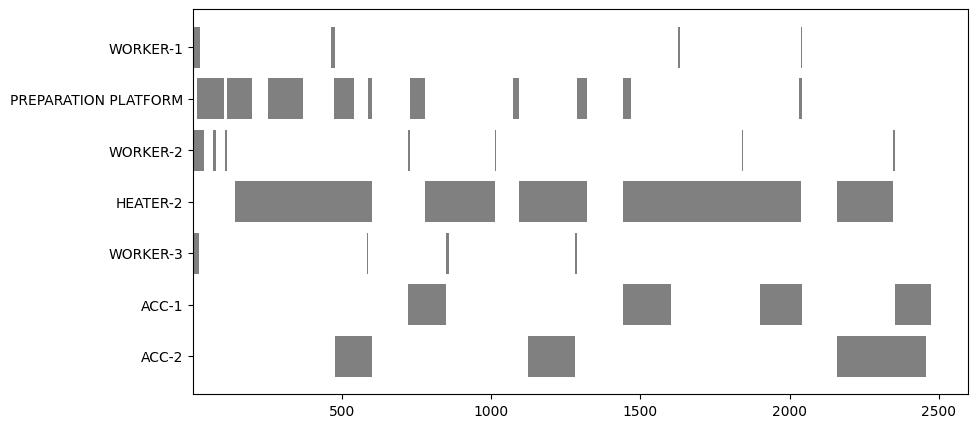

In [9]:
# put the machines in the y-axis, following the gantt chart from the previous cell

# plot the gantt chart with data from df

fig, ax = plt.subplots(figsize=(10, 5))

# unique operations
unique_operations = df["Task"].unique()
color_list = px.colors.qualitative.Dark24[: len(unique_operations)]
color_dict = dict(zip(unique_operations, color_list))

# color all the operations with the same color
for idx, row in df.iterrows():
    # Adding a lower bar - for the overall task duration
    plt.barh(
        y=row["Resource"],
        width=row["Delta"],
        left=row["Start"],
        # color=color_dict.get(row["Task"]),
        color="grey",
    )

#
plt.gca().invert_yaxis()

# # only keep unique labels and sort the labels and handles by labels
# handles, labels = plt.gca().get_legend_handles_labels()
# by_label = OrderedDict(zip(labels, handles))
# # sort the labels and handles by labels
# by_label = OrderedDict(sorted(by_label.items(), key=lambda item: item[0]))
# plt.legend(
#     by_label.values(),
#     [tag.replace("OPERATION_", "") for tag in by_label.keys()],
#     title="Operations",
#     # loc="upper right",
#     # bbox_to_anchor=(1.30, 1.05),
#     loc="lower center",
#     ncols=3,
#     bbox_to_anchor=(0.5, -0.4),
# )

machines_id_name_dict = {i: machine for i, machine in machines.items()}
# get y labels from ax.get_yticklabels
y_ticks_old = ax.get_yticklabels()
y_ticks_new = [fjss2.machines.get(y_label.get_text()) for y_label in y_ticks_old]
# assign y_ticks_new as the new y labels
ax.set_yticklabels(y_ticks_new)

plt.show()
# plt.savefig("gantt_chart_case0_ws_all_operations.png", dpi=300)